In [1]:
import os 

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import datetime
import datajoint 

In [3]:
from workflow.pipeline import culture, ephys, mua, analysis

[2025-06-10 14:43:49,794][INFO]: Connecting judewerth@db.datajoint.com:3306
[2025-06-10 14:43:50,872][INFO]: Connected judewerth@db.datajoint.com:3306


**_Step 1: Start Recording Sessions_**

- Recording sessions will cover the control period and drug treatments: 
    - Control: 6 hours at start of experiment, 6 hours right before the drug treatments
    - Drug Treatments: 4-AP, No Drug (after 4-AP application), Bicuculline, Tetrodotoxin

In [4]:
# Insert Multiple Sessions

# Control Data - 6 hours at start, 6 hours at end
organoid_id = "O13"
port_id = "A"

experiment_start_time, experiment_end_time = (culture.Experiment & f"organoid_id = '{organoid_id}'" & "drug_name = 'Control'").fetch1(
    "experiment_start_time", "experiment_end_time")
insertion_number = 0
session_type = "lfp"
probe = "Q983"
used_electrodes = []

recording_len = datetime.timedelta(hours=6)
session_len = datetime.timedelta(minutes=15)
N = int(recording_len / session_len)

for i in range(N):

    # start of recording
    session_start_1 = experiment_start_time + session_len*i
    session_end_1 = session_start_1 + session_len 

    # before drug treatments
    session_end_2 = experiment_end_time - session_len*i
    session_start_2 = session_end_2 - session_len

    times = [(session_start_1, session_end_1), (session_start_2, session_end_2)]
    for start_time, end_time in times:
        
        session_key = dict(
            organoid_id = organoid_id,
            experiment_start_time = experiment_start_time,
            insertion_number = insertion_number,
            start_time = start_time,
            end_time = end_time,
        )

        session_info = dict(
            **session_key,
            session_type = session_type,
        )

        session_probe_info = dict(
            **session_key,
            probe = probe,  
            port_id = port_id,
            used_electrodes = used_electrodes
        )

        # ephys.EphysSession.insert1(session_info, skip_duplicates=True)
        # ephys.EphysSessionProbe.insert1(session_probe_info, skip_duplicates=True)


In [ ]:
# Insert Multiple Sessions

# Drug Data
organoid_id = "O18"
port_id = "B"

experiment_times = (culture.Experiment & f"organoid_id = '{organoid_id}'" & "drug_name != 'Control'").fetch(
    "experiment_start_time", "experiment_end_time")
experiment_times = np.array(experiment_times).transpose() # 4x2 array

insertion_number = 0
session_type = "lfp"
probe = "Q983"
used_electrodes = []

session_len = datetime.timedelta(minutes=15)
N = experiment_times.shape[0]


for i in range(N):

    experiment_start_time, experiment_end_time = experiment_times[i,:]

    start_time = experiment_start_time
    end_time = start_time + session_len

    while end_time <= experiment_end_time:

        session_key = dict(
            organoid_id = organoid_id,
            experiment_start_time = experiment_start_time,
            insertion_number = insertion_number,
            start_time = start_time,
            end_time = end_time,
        )

        session_info = dict(
            **session_key,
            session_type = session_type,
        )

        session_probe_info = dict(
            **session_key,
            probe = probe,  
            port_id = port_id,
            used_electrodes = used_electrodes
        )

        start_time += session_len
        end_time += session_len

        # ephys.EphysSession.insert1(session_info, skip_duplicates=True)
        # ephys.EphysSessionProbe.insert1(session_probe_info, skip_duplicates=True)


[2025-06-05 19:27:03,379][WARNING]: MySQL server has gone away. Reconnecting to the server.


**_Step 2: Understand Recording Timeline_**

- Visualize the recording timeline and when drugs are introduced.
- Know at which time points we have data avaiable: 
    - create filters for specific analysis (restrict by organoid, drug, sesison type, etc)
    - find the table which holds the desired data
    - run the script and see what data is avaiable (black=date is avaiable)

In [4]:
# Filter Tasks

# Requirements
req_organoid_id = "organoid_id = 'O13' OR organoid_id = 'O18'"
req_session_type = "session_type = 'lfp'"

keys = (ephys.EphysSession & req_organoid_id & req_session_type).fetch("KEY")

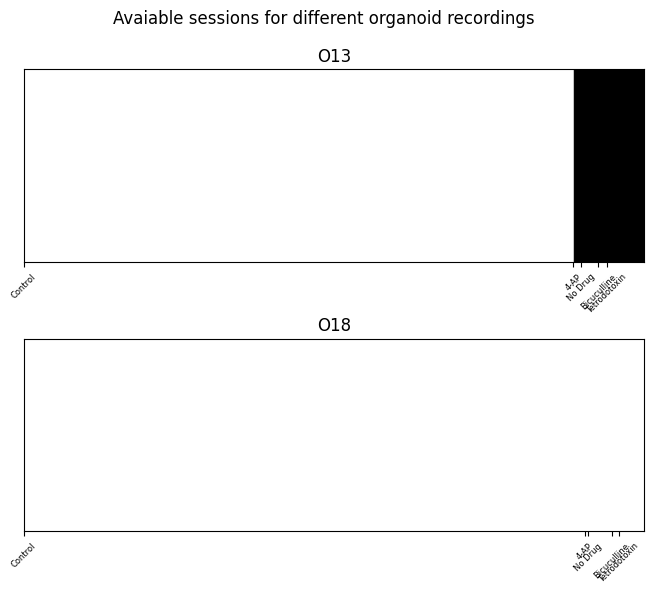

In [5]:
# Visualize Recordding Timeline

table = analysis.LFPSpectrogram.ChannelPower()
organoid_ids = np.unique((ephys.EphysSession & keys).fetch("organoid_id"))
N = len(organoid_ids)

fig, ax = plt.subplots(N, 1, figsize=(8,3*N))
fig.suptitle("Avaiable sessions for different organoid recordings")
fig.subplots_adjust(hspace=.4)

for i, organoid_id in enumerate(organoid_ids):

    organoid_table = table & keys & f"organoid_id = '{organoid_id}'"
    experiment_info = np.array((culture.Experiment & f"organoid_id = '{organoid_id}'").fetch("drug_name", "experiment_start_time", "experiment_end_time"))

    # Get start and end points for recording timeline
    recording_start, recording_end = (np.min(experiment_info[1:,:]), np.max(experiment_info[1:,:]))
    data_times = np.array(organoid_table.fetch("start_time", "end_time")).transpose()

    # Remove repeat values
    unique_times = []
    for times in data_times:
        if not list(times) in unique_times:
            unique_times.append(list(times))
    unique_times = np.array(unique_times)

    # Plot Binary Colormap for times
    recording_times = np.arange(recording_start, recording_end, datetime.timedelta(minutes=1))
    has_data = np.zeros(recording_times.shape, dtype=bool)
    for times in unique_times:
        has_data[(times[0]<=recording_times) & (times[1]<=recording_times)] = True

    date_num = mdates.date2num(recording_times)
    extent = [date_num[0], date_num[-1], 0, 1]
    ax[i].imshow(has_data[np.newaxis, :], extent=extent, aspect="auto", cmap="binary")

    ax[i].set_xticks([date_num[np.where(recording_times==drug_time)][0] for drug_time in experiment_info[1,:]])
    ax[i].set_xticklabels(experiment_info[0,:], rotation=45, fontsize=6)
    ax[i].set_yticks([])
    ax[i].set_title(organoid_id)



**_Step 3: Determine Time Periods for Analysis_**

- Given the long recording timeline, it would be wise to reduce our dataset for complex analysis procedures.
- To determine the best way to reduce the dataset, we'll use power of LFP bands and firing rate z-scores: 
    - x-axis: Time (First 6 hours of recording, 6 hours before drug treatments, drug treatments (~50 hours of data per orgaonoid))
    - y-axis: z-score for power or firing rate ((data_value - control_mean)/control_std)
    - colors: Frequency bands (Delta, Theta, Alpha, Beta, Gamma, HG1, HG2), Firing Rate (max between 5*std and 25uV)
- Plot settings
    - electrodes = (list) electrodes to be used in analysis ("all"=all electrodes, "inside"=all inside, "outside"=all outside)
    - average = (bool) average electrodes or plot individual electrodes


In [135]:
# Filter Tasks

# Requirements
req_organoid_id = "organoid_id = 'O13' OR organoid_id = 'O18'"
req_session_type = "session_type = 'lfp'"

keys = (ephys.EphysSession & req_organoid_id & req_session_type).fetch("KEY")

def get_num_elec_inside(organoid_id: str):

    elec_inside = {
        "O9": 32, "O10": 16, "O11": 20, "O12": 14,
        "O13": 25, "O14": 13, "O15": 11, "O16": 11,
        "O17": 22, "O18": 19, "O19": 20, "O20": 17,
        "O21": 18, "O22": 21, "O23": 22, "O24": 23,
        "O25": 20, "O26": 32, "O27": 26, "O28": 24,
            }
    return elec_inside[organoid_id]

[2025-06-06 14:06:23,035][WARNING]: MySQL server has gone away. Reconnecting to the server.


In [245]:
# Get LFP and Firing Rate Data

electrodes = "inside"
average = True
dt = datetime.timedelta(minutes=20)

lfp_table = analysis.LFPSpectrogram.ChannelPower()
mua_table = mua.MUASpikes.Channel()
num_bands = len(analysis.SpectralBand())

# Get LFP Data and Times
lfp_data = np.array((lfp_table & keys).fetch("organoid_id", "start_time", "end_time", "electrode", "band_name", "mean_power"))

# Check to make sure session times are the same length
if not np.all((lfp_data[2,0]-lfp_data[1,0]) == (lfp_data[2,:]-lfp_data[1,:])):
    raise ValueError("Session lengths are different size, all sessions need to be the same length (of time)")

# Make a Figure per Organoid
organoid_ids = np.unique(lfp_data[0,:])
N = len(organoid_ids)

for i, organoid_id in enumerate(organoid_ids):

    organoid_data = lfp_data[:, lfp_data[0,:]==organoid_id] 
    xticks = []
    xticklabels = []

    # Get Recording Timeline  
    data_times = organoid_data[[1,2],:].transpose()
    # Remove repeat values
    unique_times = []
    for times in data_times:
        if not list(times) in unique_times:
            unique_times.append(list(times))
    unique_times = np.array(unique_times)

    experiment_info = np.array((culture.Experiment & f"organoid_id = '{organoid_id}'").fetch("drug_name", "experiment_start_time", "experiment_end_time"))
    recording_start, recording_end = (np.min(experiment_info[1:,:]), np.max(experiment_info[1:,:]))
    recording_times = np.arange(recording_start, recording_end, datetime.timedelta(minutes=1)).astype(datetime.datetime)
    overlap_check = np.zeros(recording_times.shape, dtype=bool)

    for times in unique_times:
        
        window = np.arange(times[0], times[1], datetime.timedelta(minutes=1)).astype(datetime.datetime)

        # Check if the times have been included before
        if np.any(overlap_check[np.isin(recording_times, window)] is True):
            raise IndexError("Overlap found between sessions, change session/keys so there is no overlap")
        else:
            overlap_check[np.isin(recording_times, window)] = True

        time_data = organoid_data[:, np.all(organoid_data[[1,2],:].transpose() == times, axis=1)] # extract all sesions which contain unique sesion time








    





[2025-06-06 18:53:56,180][WARNING]: MySQL server has gone away. Reconnecting to the server.
